In [3]:
import numpy as np

import time

import gym

import matplotlib
import matplotlib.pyplot as plt
from IPython import display
import pprint
import seaborn as sns
%matplotlib inline

from dqn.agent import QAgent
%load_ext autoreload
%autoreload 2

In [5]:
# Initialize configs

# Network config
network_config = dict(
    double_q=False,
    copy_steps=50,
    dueling_architecture=False,
    noisy=False,
    gradient_clipping=False,
    gradient_clipping_norm=10.0,
    learning_rate=0.001,
    gamma=0.99,
    loss='mse',
    optimizer='adam',
    mlp_n_hidden=[32, 32],
    mlp_act_f='relu',
    # mlp_initializer=tf.keras.initializers.RandomNormal(0.5),
    mlp_initializer='glorot_normal',
    mlp_value_n_hidden=64,
    mlp_value_act_f='tanh',
    # mlp_value_initializer=tf.keras.initializers.RandomNormal(0.5),
    mlp_value_initializer='glorot_normal',
    input_is_image = True,
)

# Exploration config
exploration_config = dict(
    epsilon_init=1.0,
    epsilon_min=0.02,
    epsilon_decay=0.99
)

# Replay Buffer config
replay_buffer_config = dict(
    stack_size=1,
    replay_capacity=10000,
    add_last_samples=3,
    gamma=0.99,
    observation_dtype=np.uint8,
    teminal_shape=(),
    terminal_dtype=np.bool,
    action_shape=(),
    action_dtype=np.int32,
    reward_shape=(),
    reward_dtype=np.float32)

In [3]:
# Define loop for one episode
def run_episode(env, agent, train=False, max_steps=100_000, render=False, sleep=0.1):
    
    is_terminal = False
    score = 0
    steps = 0
    start_timer = time.time()
    
    current_state = env.reset()
    
    if render:
        img = plt.imshow(env.render(mode='rgb_array')) # only call this once
        
    while (not is_terminal) and (steps < max_steps):
        # get action from the agent
        action = agent.get_action(current_state)

        # advance one step in the environment
        next_state, reward, is_terminal, info = env.step(action)

        # update score
        score += reward
        
        # Clip the agent's reward - improves stability
        reward = np.clip(reward, -1, 1)
        
        if train:
            # save the transition
            agent.update(current_state, action, reward, next_state, is_terminal)
            
        # update current state
        current_state = next_state

        if render:
            # render the frame and pause
            img.set_data(env.render(mode='rgb_array')) # just update the data
            display.display(plt.gcf())
            display.clear_output(wait=True)
            time.sleep(sleep)
            
        steps += 1
            
    # Call to clear internal agent statistics (reward, return, etc.)
    loss = agent.finalize_episode()
    
    total_time = time.time() - start_timer 
    return {'score': score, 'steps_per_game': steps, 'framerate': steps/(total_time + 1e-6), 'loss': loss}

In [4]:
# Define loop for multiple episodes
def run_experiment(env,
                   agent,
                   runs=100,
                   plot_stats=['score', 'framerate', 'steps_per_game'],
                   history={},
                   **kwargs):
    # Default parameter for render is False
    render = kwargs.get('render', False)
    
    if not render:
        num_plots = len(plot_stats)
        fig, axs=plt.subplots(num_plots, 1, squeeze=False, figsize=(10, 5*num_plots))
        axs = axs.ravel()
    
    for i in range(runs):
        stats = run_episode(env, agent, **kwargs)
        
#       Update history object
        for k, v in stats.items():
            if k not in history.keys():
                history[k] = []
            history[k].append(v)

        if not render:
            for ax, stat_name in zip(axs, plot_stats):
                ax.clear()
                sns.lineplot(x=np.arange(len(history[stat_name])), y=history[stat_name], ax=ax)
                ax.set_title(stat_name)
            display.display(fig)
            display.clear_output(wait=True)
#             print(f"episode {i}/{runs} | {stats}")

In [1]:
# Recomended environments: Acrobot-v1, CartPole-v0, MountainCar-v0
from env_wrappers.stack_env_wrapper import StackEnvWrapper
env = gym.make('CartPole-v0')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
env = StackEnvWrapper(gym.make('PongNoFrameskip-v4'),                 
                 frame_skip=1,
                 terminal_on_life_loss=False,
                 screen_size=84,
                 stack_size=4,
                 skip_init=1)
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

NameError: name 'gym' is not defined

In [6]:
from train import run_episode
import gym

env = gym.make('PongNoFrameskip-v0')

agent = QAgent(observation_shape=env.observation_space.shape,
               n_actions=env.action_space.n,
               gamma=0.99, # discount of future rewards
               training_start=50, # start training after x number of steps
               training_interval=1, # train every x steps
               batch_size=32,
               priority_replay=False,
               network_params=network_config,
               exploration_params=exploration_config)

TypeError: __init__() takes from 2 to 14 positional arguments but 15 were given

# Vanila DQN

In [7]:
agent = QAgent(observation_shape=env.observation_space.shape,
               n_actions=env.action_space.n,
               gamma=0.99, # discount of future rewards
               training_start=50, # start training after x number of steps
               training_interval=1, # train every x steps
               batch_size=32,
               priority_replay=False,
               network_params=network_config,
               exploration_params=exploration_config)
# Define history object to hold all statistics. Usefull if you want to continue training
history = {}

TypeError: __init__() missing 2 required positional arguments: 'stack_size' and 'replay_capacity'

In [ ]:
run_experiment(env, agent, runs=1, render=True, sleep=0.0)
env.close()

In [ ]:
env.frame_skip

In [ ]:
run_experiment(env, agent, train=True, runs=500, plot_stats=['score', 'steps_per_game', 'loss', 'framerate'], history=history)

In [ ]:
run_experiment(env, agent, runs=1, render=True, sleep=0.0)
env.close()

# Double DQN

In [ ]:
network_config['double_q'] = True

agent = QAgent(observation_shape=env.observation_space.shape,
               n_actions=env.action_space.n,
               gamma=0.99, # discount of future rewards
               training_start=50, # start training after x number of steps
               training_interval=1, # train every x steps
               batch_size=32,
               priority_replay=False,
               network_params=network_config,
               exploration_params=exploration_config)
history = {}

In [ ]:
run_experiment(env, agent, runs=500, train=True, plot_stats=['score', 'steps_per_game', 'loss'], history=history)

# DQN with Priority Replay

In [ ]:
network_config['double_q'] = False
network_config['learning_rate'] = 0.001

agent = QAgent(observation_shape=env.observation_space.shape,
               n_actions=env.action_space.n,
               gamma=0.99, # discount of future rewards
               training_start=50, # start training after x number of steps
               training_interval=1, # train every x steps
               batch_size=32,
               priority_replay=True,
               network_params=network_config,
               exploration_params=exploration_config)
history = {}

In [ ]:
run_experiment(env, agent, runs=500, train=True, plot_stats=['score', 'steps_per_game', 'loss'], history=history)

# Double DQN with Priority Replay

In [ ]:
network_config['double_q'] = True
network_config['learning_rate'] = 0.001

agent = QAgent(observation_shape=env.observation_space.shape,
               n_actions=env.action_space.n,
               gamma=0.99, # discount of future rewards
               training_start=50, # start training after x number of steps
               training_interval=1, # train every x steps
               batch_size=32,
               priority_replay=True,
               network_params=network_config,
               exploration_params=exploration_config)
history = {}

In [ ]:
run_experiment(env, agent, runs=500, train=True, plot_stats=['score', 'steps_per_game', 'loss'], history=history)

In [ ]:
run_experiment(env, agent, runs=1, render=True, sleep=0.0)
env.close()

# Dueling Double DQN with Prioritized Experience Replay

In [ ]:
network_config['double_q'] = True
network_config['dueling_architecture'] = True
network_config['learning_rate'] = 0.001

agent = QAgent(observation_shape=env.observation_space.shape,
               n_actions=env.action_space.n,
               gamma=0.99, # discount of future rewards
               training_start=50, # start training after x number of steps
               training_interval=1, # train every x steps
               batch_size=32,
               priority_replay=True,
               network_params=network_config,
               exploration_params=exploration_config)
history = {}

In [ ]:
run_experiment(env, agent, runs=500, train=True, plot_stats=['score', 'steps_per_game', 'loss'], history=history)

# Noisy Dueling Double DQN with Prioritized Experience Replay

In [6]:
network_config['double_q'] = True
network_config['dueling_architecture'] = True
network_config['learning_rate'] = 0.001
network_config['noisy'] = True

exploration_config['epsilon_init'] = 0.0
exploration_config['epsilon_min'] = 0.0


agent = QAgent(observation_shape=env.observation_space.shape,
               n_actions=env.action_space.n,
               gamma=0.99, # discount of future rewards
               training_start=50, # start training after x number of steps
               training_interval=1, # train every x steps
               batch_size=32,
               priority_replay=True,
               network_params=network_config,
               exploration_params=exploration_config)
history = {}

KeyboardInterrupt: 

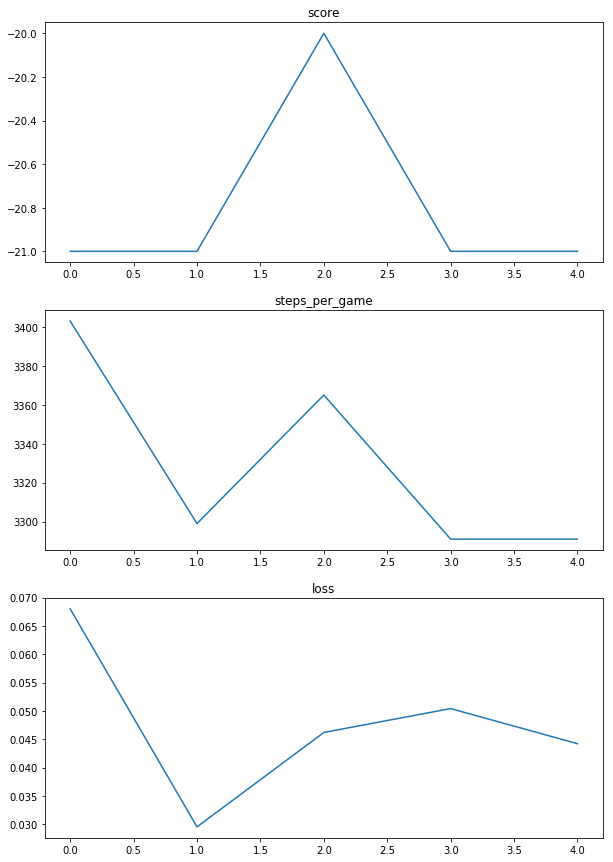

In [7]:
run_experiment(env, agent, runs=500, train=True, plot_stats=['score', 'steps_per_game', 'loss'], history=history)